In [1]:
from pathlib import Path

import pandas as pd
import pyvista as pv

from fepredict import __file__ as filestr

In [2]:
module_dir = Path(filestr).parents[2]
del filestr

 # Import the mesh
 I put a subset of the real data in `data/raw`. You'll need to update your environment
 with the new environment.yml file before the pyvista script works.

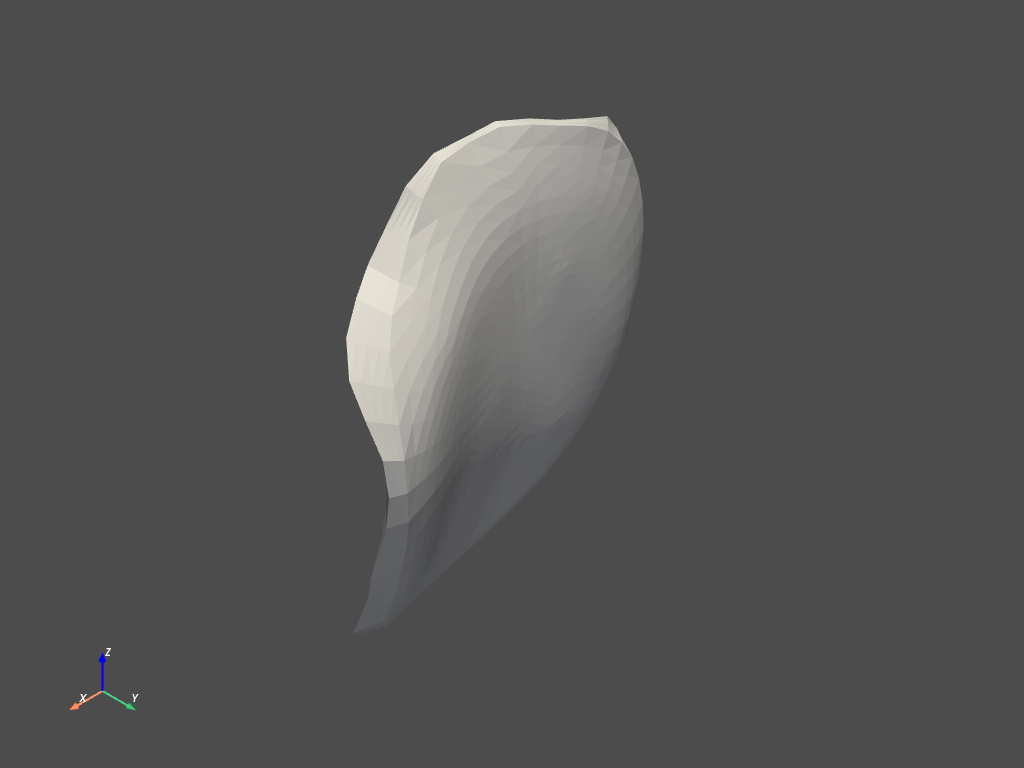

In [3]:
raw_data_dir = module_dir.joinpath("data", "raw")
simulation_dir = raw_data_dir / "9905863M00"

tibia_cartilage_lateral = pv.read_meshio(
    simulation_dir / "TIB_CART_LAT_G.inp", file_format="abaqus"
)
tibia_cartilage_lateral.plot(jupyter_backend="static")

 # Import the contact pressure data

 The columns are frame number, just think of as time or "percent of knee flexion
 activity". The rows are node numbers.

 > **Note**: Abaqus users and Clare will refer to them as
 >           nodes and elements, but pyvista uses points and cells.

In [4]:
cpress_tib_cart_lateral = pd.read_pickle(
    simulation_dir / "CPRESS_TIB_CART_LAT_NODES.pckl",
    compression={"method": "gzip", "compresslevel": 1, "mtime": 1},  # important line
)
cpress_tib_cart_lateral

,frame_000,frame_001,frame_002,frame_003,frame_004,frame_005,frame_006,frame_007,frame_008,frame_009,...,frame_231,frame_232,frame_233,frame_234,frame_235,frame_236,frame_237,frame_238,frame_239,frame_240
node_num,,,,,,,,,,,,,,,,,,,,,
49800001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49800002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49800003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49800004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49800005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49802836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49802837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49802838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Contact pressure is a surface output, so the data will not include the interior nodes.

In [5]:
tibia_cartilage_lateral.n_points  # includes interior nodes

2840

In [6]:
cpress_tib_cart_lateral.shape[0]  # only includes surface

1274

 To get a time series from this data, for easier machine learning implementations, we
 can do the maximum contact pressure.

<AxesSubplot:>

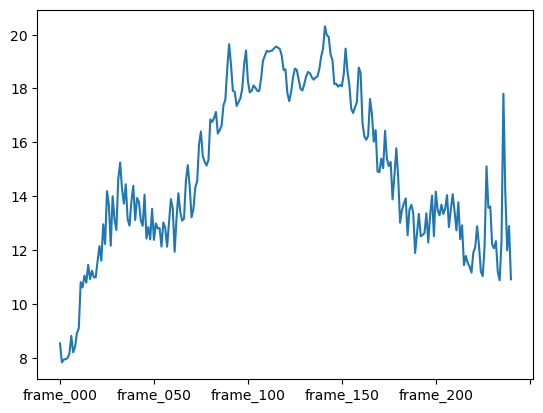

In [7]:
cpress_tib_cart_lateral.max(axis=0).plot()

 Working with these time series would give you enough information to find
 outliers/failed simulations, and you could start a machine learning pipeline before
 worrying about contour plots.

 # Advanced data loading gameplan
 1. Create point_data array mapping node numbers from _TIB_CART_LAT_G.inp_ to the 0-based
    indexes of `tibia_cartilage_lateral`.
 2. Preallocate point_data contact pressure array with zeros because contact pressure
    is only output for surface nodes. Then, fill in the values you have.
 3. Make your new point_data array the active scalar, then plot with colorbar.
 4. Make an animation across all the frames to confirm that results make sense to
    domain scientists (centralized blob on top of cartilage, without jerky movements)